In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2 as cv
import numpy as np

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
images_csv = pd.read_csv('emotions.csv')

In [4]:
emotions = images_csv['label'].unique()
emotions_dic = {}
for index, emotion in enumerate(emotions):
    emotions_dic[emotion] = index

print(emotions_dic)

{'sad': 0, 'scared': 1, 'neutral': 2, 'happy': 3, 'angry': 4}


In [5]:
e_images = images_csv.replace(emotions_dic)
e_images.head()

/tmp/ipykernel_8725/3825047754.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  e_images = images_csv.replace(emotions_dic)


,image_path,label
0,/home/adam/Bachelor/emotions/sad/image0029680.jpg,0
1,/home/adam/Bachelor/emotions/sad/image0024066.jpg,0
2,/home/adam/Bachelor/emotions/sad/image0009807.jpg,0
3,/home/adam/Bachelor/emotions/sad/image0018272.jpg,0
4,/home/adam/Bachelor/emotions/sad/image0026864.jpg,0


In [6]:
X = e_images['image_path'].to_numpy()
y = e_images['label'].to_numpy()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=123, stratify=y)

In [8]:
class CTDataset(Dataset):
    def __init__(self, image_paths, labels, device = 'cpu'):
        self.image_paths = image_paths
        self.labels = labels
        self.device = device
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv.imread(img_path, cv.IMREAD_COLOR)
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        image = cv.resize(image, (100, 100))
        image = torch.tensor(image, dtype=torch.float32)
        image = image / 255.0
        image = image.unsqueeze(0).to(device)
        label = torch.tensor(label).to(device)
        return image, label

In [2]:
class CNN_model(nn.Module):
    def __init__(self):
        super().__init__()
        # First layer
        self.conv1 = nn.Conv2d(1, 10, (3, 3))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(p=0.25)
        # Second layer
        self.conv2 = nn.Conv2d(10, 30, (3, 3))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(p=0.25)
        # To linear layer
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(15870, 500)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.5)
        # Final layer
        self.linear2 = nn.Linear(500, 6)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.linear2(x)
        x = self.logsoftmax(x)

        return x

In [10]:
train_data = CTDataset(X_train, y_train, device=device)
train_data_loader = DataLoader(train_data, batch_size=10, shuffle=False)

In [11]:
test_data = CTDataset(X_test, y_test, device=device)
test_data_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [12]:
def train_model(data, model, n_epoches = 50, learning_r=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.train()
    opt = optim.Adam(model.parameters(), lr=learning_r)
    loss_fn = nn.NLLLoss().to(device)

    losses = []
    epoches = []

    for epoch in range(n_epoches):
        N = len(data)
        for i, (x, y) in enumerate(data):
            opt.zero_grad()
            losse_value = loss_fn(model(x), y)
            losse_value.backward()
            opt.step()

            epoches.append(epoch+i/N)
            losses.append(losse_value.item())
        print(f'Epoch: {epoch+1}/{n_epoches}, loss: {losse_value}')
    
    return np.array(epoches), np.array(losses)

In [13]:
epoch_n = 30
learning_rate = 0.001
f = CNN_model().to(device)
epoches, losses = train_model(train_data_loader, f, n_epoches=epoch_n, learning_r=learning_rate)

Epoch: 1/30, loss: 1.1638810634613037


KeyboardInterrupt: 

In [14]:
# Export to model.pt
torch.save(f.state_dict(), 'model.pt')

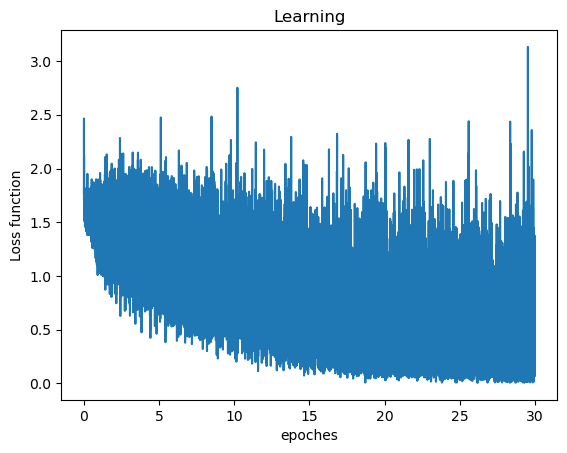

In [15]:
# You can see there whole learning process
plt.plot(epoches, losses)
plt.xlabel('epoches')
plt.ylabel('Loss function')
plt.title('Learning')
plt.show()

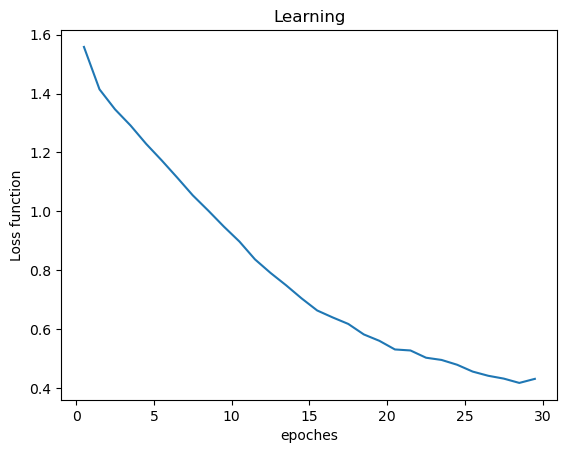

In [16]:
# More readable form but it shows less information what happens here
epoches_avg = epoches.reshape(epoch_n, -1).mean(axis=1)
losses_avg = losses.reshape(epoch_n, -1).mean(axis=1)
plt.plot(epoches_avg, losses_avg)
plt.xlabel('epoches')
plt.ylabel('Loss function')
plt.title('Learning')
plt.show()

In [5]:
# Import model.pt
f = CNN_model().to(device)
state_dict = torch.load('model.pt', map_location=device)
f.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
# It changes model to evaluate mode (that means you can use it)
f.eval()

CNN_model(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(10, 30, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=15870, out_features=500, bias=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=500, out_features=6, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [14]:
def whichEmotion(loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    emotions = []
    for prediction in torch.exp(f(loader)):
        emotion = torch.argmax(prediction)
        emotions.append(emotion)

    emotions_tensor = torch.Tensor(emotions).to(device)
    emotions_tensor = torch.Tensor.int(emotions_tensor)

    return emotions_tensor

In [20]:
def accuracy(loader, data_len):
    positives = 0
    for i in loader:
        positives += torch.count_nonzero(whichEmotion(i[0]) == i[1]).item()

    return positives/data_len

In [21]:
# train data accuracy
print(f'Accuracy for train data: {accuracy(train_data_loader, len(train_data))}')

Accuracy for train data: 0.9669333333333333


In [22]:
# test data accuracy
print(f'Accuracy for test data: {accuracy(test_data_loader, len(test_data))}')

Accuracy for test data: 0.505


In [16]:
example = None
data_e = None
for i in test_data_loader:
    example = f(i[0])
    data_e = i[0]
    break

In [17]:
example

tensor([[-2.2325e+00, -2.3877e+00, -5.4083e+00, -2.8780e-01, -3.0683e+00,
         -4.0319e+01],
        [-5.0472e-04, -1.0073e+01, -1.2014e+01, -7.7852e+00, -1.0113e+01,
         -7.6989e+01],
        [-2.2314e+00, -5.5810e-01, -2.9887e+00, -1.7053e+00, -2.4277e+00,
         -1.8253e+01],
        [-4.6773e+00, -3.6781e+00, -2.5865e+00, -1.2105e-01, -5.4838e+00,
         -3.3549e+01],
        [-2.5422e-02, -4.2984e+00, -8.7017e+00, -8.9836e+00, -4.4901e+00,
         -7.2639e+01],
        [-6.3999e-01, -1.9885e+00, -1.6817e+00, -3.7217e+00, -2.0749e+00,
         -3.3900e+01],
        [-2.1409e+00, -3.3577e+00, -1.3405e+00, -7.7450e-01, -2.0794e+00,
         -3.7489e+01],
        [-6.5994e+00, -1.0639e+01, -4.6130e+00, -1.1835e-02, -7.6892e+00,
         -1.6890e+02],
        [-2.7757e+00, -2.9890e+00, -1.1130e+00, -1.3325e+00, -1.2209e+00,
         -1.7682e+01],
        [-1.3820e+00, -2.8369e+00, -5.7409e-01, -3.3139e+00, -2.3999e+00,
         -2.1606e+01]], device='cuda:0', grad_fn=<Log

In [18]:
emotions_dic

{'sad': 0, 'scared': 1, 'neutral': 2, 'happy': 3, 'angry': 4}

In [32]:
def translateOutput(output):
        emotions = {'sad': 0, 'scared': 1, 'neutral': 2, 'happy': 3, 'angry': 4}
        answers = []
        exp_output = torch.exp(output)
        for pred in exp_output:
            answer = {}
            for i in emotions:
                answer[i] = pred[emotions[i]].item()
            answers.append(json.dumps(answer))

        return answers

In [33]:
answer = translateOutput(example)

In [34]:
answer

['{"sad": 0.10726499557495117, "scared": 0.09184172004461288, "neutral": 0.004479250870645046, "happy": 0.7499119639396667, "angry": 0.04650209844112396}',
 '{"sad": 0.9994953870773315, "scared": 4.2217059672111645e-05, "neutral": 6.060041414457373e-06, "happy": 0.00041583794518373907, "angry": 4.05577193305362e-05}',
 '{"sad": 0.10738331824541092, "scared": 0.5722964406013489, "neutral": 0.0503547303378582, "happy": 0.18172572553157806, "angry": 0.08823979645967484}',
 '{"sad": 0.00930444709956646, "scared": 0.025271231308579445, "neutral": 0.07527953386306763, "happy": 0.8859913945198059, "angry": 0.004153419751673937}',
 '{"sad": 0.9748982191085815, "scared": 0.013590488582849503, "neutral": 0.0001663056609686464, "happy": 0.00012544423225335777, "angry": 0.011219630017876625}',
 '{"sad": 0.5272974371910095, "scared": 0.1368960589170456, "neutral": 0.18605172634124756, "happy": 0.02419203333556652, "angry": 0.12556277215480804}',
 '{"sad": 0.1175437793135643, "scared": 0.03481350466

In [75]:
with open("happy.jpg", "rb") as image:
  g = image.read()
  b = bytearray(g)

In [85]:
np_b = np.asarray(b, dtype=np.uint8)
img_bytes = cv.imdecode(np_b, cv.IMREAD_COLOR)

In [104]:
rgb_image = cv.cvtColor(img_bytes, cv.COLOR_BGR2RGB)
resize_image = cv.resize(rgb_image, (100, 100))
std_image = resize_image / 255
std_image = np.moveaxis(std_image, 2, 0).astype(dtype='float32')
std_image = np.array([std_image])
preprocessed_data = torch.from_numpy(std_image).to(device)

In [105]:
data_e[0:1].shape

torch.Size([1, 3, 100, 100])

In [106]:
preprocessed_data.shape

torch.Size([1, 3, 100, 100])

In [125]:
f(preprocessed_data)[0]

tensor([-3.0075e+01, -9.0111e+00, -2.9289e+01, -1.2206e-04, -1.9257e+01,
        -1.8013e+01], device='cuda:0', grad_fn=<SelectBackward0>)

In [134]:
def translateOutput(output):
        emotions = {'Surprise': 0, 'Sad': 1, 'Ahegao': 2, 'Happy': 3, 'Neutral': 4, 'Angry': 5}
        answer = {}
        exp_output = torch.exp(output)
        for i in emotions:
            answer[i] = exp_output[0][emotions[i]].item()
            
        return answer

In [135]:
translateOutput(f(preprocessed_data))

{'Surprise': 8.680870692417963e-14,
 'Sad': 0.00012204790982650593,
 'Ahegao': 1.9049578537863598e-13,
 'Happy': 0.9998779892921448,
 'Neutral': 4.334438141739838e-09,
 'Angry': 1.5028218669499438e-08}

In [7]:
import base64
from PIL import Image
from io import BytesIO

In [8]:
base_64_string = "b'_9j_4AAQSkZJRgABAQAAAQABAAD_2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL_2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL_wAARCACiAKIDASIAAhEBAxEB_8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL_8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4-Tl5ufo6erx8vP09fb3-Pn6_8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL_8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3-Pn6_9oADAMBAAIRAxEAPwDhNQ1e41C4M087O55GMgD8KptKDy53ehPb86ou5Zs7V9ckmoXlIyMKD6jJrnsdmxfkmjVcfLu7mqMkyltq5LE4AHU_lUGJrhtqEfXoKtiKK0XyosyXDD5m9PYVXKHMULmQI20qC3f2qKMvI23aMnoAMnntipjbSzzogXDMRn2GcDNdjo_hpQgYoWdsHJFTKaiONNzOZtdKkmYMUYD17A1pR6EoY7u3JJWu7s_Dj7QUG0DuQOv1rWtvC8TcktIxPJOMe_tWLrXOqOHSR5qulYXCBmz2xWtp3heSdgZQFXI4PGRXpkOiWFv8irtI53HjA74PSrH9nQhNyKG4yMAHrUucmUqcEzmLLRra1iwqgsOAc5INW5LASYOArE8gYzgCt5bAIvAI6gA9zTo7NU5QA8cnOeaz1NLxOVk0BHB3Id3JBGAfzrKudBY78NuyMEnGQceor0J7RXIXZwf4sc81G-nojY2jB56cH8qauhWizx_UNBYOcwgArjcOQOa5y706aAE8kdiPr3Fe4ahpCMrv0OeTjIrk9V0tX3FU2MF6juB7VpGoYzpK10edW969tIGbdkcKenXrkjtXo3hnxXdvb7IrpQyYBjJBOAOgz2xXE32mqjbkjGRyDyO_Y1BpdzLaX-5H2SBssCgIx6EkZxWyfY5WraM93svEby7Y5bWVWI--CCDjuD3x3xW9G0vlCbcCpGQD0P0I4rz7w3qdrqMBiSZI7ng5yNpI9R2_Cuy069MTtBOrJMvDRjkEf3l9RWiZjJGp9oT-9RT_ADrfH3oqKok-VZpRycBQOpJqrvVzkE47n1-lU8vO25ySOwqZnGwenQAdaVrGqbZcW5b5IoVBcnC49-9a8NvBaREH55iMMR_Ex7D2FYlo5jl3KAZDwCei_Suj0axeedDIOepJ6AE5_Wpk7FwjzM0NC0gvcGaWPezjOPQAjAr0rTbRBaxZUZwOnXmsbRbYRq9wVwhBRR0JA54-proLRCkCAj5yoH4D_CuSTuzvjHlRdjgjiA3IOew9fWrajEaYxgcg-5FVI8EBmcDt2x-FXyo8sA5x2A_lSSBsibLqWK7wc4HqPTmmRhg5XJxgADsPYVaSKTaSwGM8ZPbHf3pfKCMCy8k4I9D-NOzE5W0GbGIyDyccHPAojI3urHBHAweT-dS52E5x7ZPWmb1LHkHtnHcVTIV2KSqqMnr3qMAlSSRuHQAcY7UYG75cnnOO3J61IIicMzcj2xmkPYrMilScnaOMHoM1j32mq6naO2c_Uc81vNGFyCCQeSP8Kjkizlh6dP8AGk4j5jzPVdIKREmM8cEgZ_GuGvUaGQI7Bl6qCOfzFe06na7UJAPI5xzivPdd0wSEyQqqk9QOhPrg9M1cGZVEjmbS9eGUMm0EdgCD_wDXrvtH8aNLbxw6iW_dY8ucclccYOOcV57NEDlmQB1OGI4PHfFJHd-S24YZSBlT3rbzOdq-570mtQtGrLcS7SARx2_KivEBrEygBZJAo4A3dqKfMR7M5NXwcD8-1CkDlic0xT2Uc09FwQT1_nViNHToWmlAx17e1ekaNpjNEpAwDgkdM1yHh21DzoCMknoegr1fTY1jgAAGQMEj1rlqy1O2hDS5LBEPkXOMDAHTgVr20BPzOT8wxgdB7iqtvAGnOF3MeSewxWzaReTIxZdwPIArOKuazlZEH2YCQLtO0DAPUY6_zq9bwgKBg5HIJzU2FHzOVjB6jIyRSNe2UIAW5iBVckFgeBWsYmDqu1hTGyqMKDk5JPpS4LAeo6Y_rUsE4lTcMMpPUcg96kKgOOOvcelOyFzFCS2keQNnkDhSB19aSGyKnDHJPUE84_GtFhiVDjjkE026lhsoDcTEiNQSSOT-FLlH7VpWIVgVeAOKbJEcgkEkHK49cVm3Pi7ToFyuWO7btI5z34Hpnmsubx_pySFDGd68nByD7ACq5UyPaM6FgQ2WU5PGaikADDHY4-uPesGHxh9p4gsZJAeQAcYB9SRitG31SG5YI48uU5Ow5yPxxUNWLTuRahGWjdkzkdR2_KvONdlaFzldoOQfQ16VdOFwc8HrXDeLrANA8yjGeuOlSnqU43R57dToZjkHBGM9yPf6Vj3TGNvlPA6H_PtVm5JOUfqOh_z2rPlkDoyMfmH3Se4roirnM3YeLhsd6Kob_cflRV2IuIpwPYVat48gOe_OKprknkf5FacB2JG20ZIG0EcfjTZMdTq_DEZNwGPQcnHTFenWLl7fAz0zn2rzvw_GYrIsfvE9fqcV6BAVisViA3NNhF7YHc5rknqzvg7RFtpdTvXP9nCNIg2GkIBLHoev9KfdWHi2JSYZxIh5IQAH-mcVs2UUcNsIYcx44AAyDjnPWrK6ksRIlniyFLEHrgcHjOB1q427Gck2eU6xc-IYLgC7iuI3BOGJIBz6EGorfVrqbKXMpfzFAYE4IIPB9_SvR18S6be2xaREkHIZWAPIGfTvVLyPD9ySwtYUcqCQFHUjIH1qmyY07m14Z1GL-yY4S-5x0GeTn_CujhG9gT-A7CuBWK3sZ0azl8sMRnkkfSus0-9CwKWYE-vY-9ZqSvqXKGmhrSEo-7OcdjWF4k1mJNOmQ4L9Ap65Pfir814kgbY2WxkDBwR7E1hSSWkjTSzAMUIAyORn0qr36ijDujzCaDUdUuTHbJIFbjkFR174GcfU12fhrwBDCyXOq4kcHKpuJAB55xxU1_4msdJTcNi84PIBPrgdelZcfj1JLkfZbO6nBxjZGTkn0NNX2CUEtT0uKK0gURwRRAAdABniqOp2FtcwHdGgkHO_BJH4CvP7r4gX1sczaJP5RYgNKpBxnjp0P41Y0v4kaXNJsmEsEhbGxyWGMdcn19KcrkqK7nSYE-ntEeJouMc9-hrLvEW8sWidRkgqc-tbFvfRXcnnw42soJwQRz05rPvYvLuyVHyyZOOwrGSNYt7M8S1i1NpqEkTKQAx2nof8_Wsl4klkI2_N2A4J_DvXoHjrTl2rcqvqGI68c5_CvPpoWJxjJHQiuiDurnPUjZ2G_Z19D_3y1FL5l3_fm_76orQxKkYC9TuPYDp-Jq1b7pbiPPJLAD3P_wBaoY9iNt25Ynp2rU0C1NzqaOcYTkDsAKJOyY4rU7jTYSsUEXcsAf5n-VdZNepax_aJT-7hAAA7k9awrOLEiMc8c5_Ct-300ajZFZR-7JBIPt3rjvqd9jmbnxnqep3gttIs2PBQMQcHnqcf41e0_wAIa5qkudT1GSNTyEjxkEjnk12ulaLb2KqIEUYHJGBj6kCujggYKPmIPr61tF9jGeh52vw7MKFUvrgDdnBIwRx1wPari-FhbMC0875IxyD9e1d-yRJgnBwOeearSCMA7VHHOfSnNXCnN9jmW04JaOzBgVUBRnknqMU-2EhEUWXOOST1_HjirF87TybeTEjbmw2Ce_GKdbuXfMWCQAAXyTgdenJrnZ0Ruywyv5JCuMZwP8agjs0cSK2PMYEqScgg9QD7VfZ8DATPGMg1DCq3QMWSjq2R_XFOwmmkZyeHbN2J-zx5P8ZUFsn3PNa1vo8VvgRooHYgYx-VLFvSVlbqpwePyJHer0cr4GBwOhHQ1tFoynzPYrzadBPEUmiQjpjYCTXP6l4R0a6ARrKIs38RXofXjH866zzXPBHB6ZHpTwgdeVGOxPUGiWpCbRyNpoC6XEVt2OMAEEAZA6dKbIjSOQc8DiunkiOTx04z1rIuoPLk3hcqeoHr2rKUbGqlc4LxbAx04kjlWBwe46V5hPDscENsCkjJ7emfb3r2rxDZLdadIEI5UlQeuRzivHL5wk-11-Ujg9c-ua0ovQyrLW5TMsgODbPn60U3zlHHnL-dFbGFygqH73AYjAH14rpvCsANwcDgjGfXHWuZBIGAR7ke9d14St8MWK_dABHXrzUzehVJe8djbQHaAvUgAfU9TXUWEBSBEU8Dgg98nmsbTIRNdFj9wYA_lXUQxqFAPQY6flXId3kaNtHhAFHA6ADirBJ2kHqeBzUcLBVJ7dR2qzGgfDNyBzjtWyTsYySRAIm57jjn3pJIj5eAevQVfKEHCjr37VUu5VtY94-aQ8KD6mm1YFJvYwbyI2-UDfO_BH49atafBCgClhk-lc_quppa-dczMTszkgZOB6CsPRviDpl9qKWn7-GVmIXzUwCe3IPH41EddTo1tbqenyJAkYO7J7VQdB5u-NsEcg9qqy6gq2sj4LlVztHUn0rzSbxp4ri1swPp0cMSsB5JUsSD0O7Peq3QrNaNnsEDwznEo2S9Nx_kfarQtguVJIBXGQenuDXO6fqAu44GliMZkGGQ8EEj-hrZtLwpK1pctkj7jHuD_h3pJp6Gc4OLLnltgAdulLyqgHgntUqhdoAPANEmMD_PNaWMeYqshIHYgn8qqXEeVKt09frV5iRnkcVWmPynGD0_-vUMpHN3cSgOu3rmvGfFFmtpqctuwABYtG2OADzg17jfINob35PTivJfiFbFNQjnTgjGcjjBz_hShpIKmsTgfsvPSitDcf8AnnH-tFbc5h7Mx4AGkQDscke_QD869D8KlT5-W5-UevTI_pXAWkUm4EIclhyfrXdeD2xqE0WcqVbJxzkHj9DSnsOno7nomjhQv-1nI78g10kIwwbt6da5vSyUXOeldBauNu4_l6mudHY9rmgrZUnPAHPHpV-A7lA9KzoyRjnocZq1G5CnC-vGeatMzaui60owCe1ZE2Z5ZJc5EeQpPTPc1YupzHas-fmxgD1J6CqLSGG1CNyx4J9zyTRJ3HCNjlf7OuTfTb1WeCRidp6jPX8KiHg6xW4e4igVHJyD2GfSukUjdwD2Bx3zV638rBJHGeahM3nJoytPspUOZcE4wK0BZxBxK0KmQDgkAnP41ox29r1AJPfnpmlkWJQSp4x0z6da0toZ-0d9jJ-z5nErHLr90dh9anuEle2SZEzLEdwx1I7j8RTnA5IYEnJHGOOw4p0FwQ2HG3Ixg1A3JsvWd0k8QYN95QRirJJxkH3z7Vi2rm2vpYD91vnj-hPIH0NbGQQMHt-lXF3RjUik7rqRSMVwAM7qjYZUnpn-dSvgn3BwKibOCR3HA96GQ2ZV4nBBOScVxuvaZFe3yeYmUCgfzNdtdjepyvPf8ulZV3ENrskRkl2gKoHX_OamV7GkGuY47_hHLFeNq8cdBRW9_ZMv91_yorPU6dDxsRAOiKgxvHPc45Oa6_wnaKl_IR0MRPvnIzWNFp-ZwyKxVQDkjjJ6gflXTaBaS2128z_KpjOF9eQCa2bOZxSTOmsQQ20nrkg_TtW_akhBkfTFYNiQ7EHtyD9K34OFGORnNZvcvoX4SCSOnHFWoyMgKPxNU4UDvzwSMGr0XYdMVojO6Kl4waWOMjgZcge3A_WsrUZ0hZMt1_h9a0rnieVz1ACg-3U1xF_qZOoSOx3FWAUE8E9BU2ub0Vd-SNhLlpFLlvLULgAnj8qje_2Sqv2jqOu7j6cVr6b4dDfZ5rlBOZcEseVjBGcAdPxroU0yJZ0QRRBMZyEAPHbpWigyniacXbc5CDU2hTBI5BBJyc59qadRBBLcHnggjg-2K7q4sxGieWgKswBBAI-oNJNYosJcKGIGcYHP5dKqzM_rlPexwa6hECN0xTOcBsgc9OSKtJeuhDOweM9GHpmuqmsA0UZaNG3YBDDIANcr4isP7MnRrWPELLmVAOBzjIHQYNTJaamka1Oo-XqadwN8Ec6HmIhgR3HcflWtCweMEdDg_nXO-H5TNYmJzuCkjJ7g9K3rEYtkB5IyPy4pWsznq6Xj2JJFGc9s1EwyvoRUzAk_So5Ado4xnqDQzK5nXQG04Bz_APXrOkt5prmGWJivksGYDqQeMVpXRJ_Gm6e6CedndVAIGD1PFK11YqOjuaImTaNw-bvxRVYyw5P7wUUaFWZ5sbeOSeEIBktnHQEHkGrl5b-TMHQYVUK59SeTWL4V1JLnSIGmbM1s3lSE8kccE_UYra1CWfbsIU7uQe2KnZ6nRK0o3Q7TpCsvHOeOa6e1PbgdDx3FcZp8pE6r-H511lo-VGOo_Wp6mXQ1oh8w7Z5HrWjABnHXjisiE_cBBABxk1rW5O7HY1cdTKSKN3GR9oOOuR-lcLpunibxDO0wV4rY7pI2GSQwIBH0616PcQ7_ADAOCcEfSvHbzxbLY63fxWqIkqzsu9gfujggjv0rSK1KhJuLSO81TxjBoGnx5QyMhACjptzgZI9q5q3-M8w1HdeaWotApCpC-X3EggktwRgdOK4HWdWa9YLzlm3Mc8Fj3x7VlxxB2xnr3p3YexhbVantD_GnRSoH9naicYJ-5x-tN_4XZonlOG03UM44HyYP454rx2WDylOcE8EEc5FV5U3KCBz3p8zJ9hDse0TfGfR5IkFvYXpkDDiQKBjucgnp9K34NfsNftZIQ6pLcKUKFhuCkZJBHXivm_LRsCOoPFaC6zPDAEAbyx0KnBB9j6UXuP2Mbe6e5eF2jEl3bI5cQSlAx6kdj9D2rqrMYjcDsxryH4S6ld3utX0czF4xEpBPJ4IA5-hr2KADy5PXcTUvcKjbd2Dkcg-vBqCV8px1J4qVvmyfXiqs5Kr2x6-nvUszSKk2SwPpxin6XGm2R3AyWOSRzgcUxyBnnjrWdpOrtI91DND5KoS6OT8rqT1yelLTqWjTKIxJ8vrz0orMbxVoqsQdUs-Dj_WiijQu_meF-H9aXSdaJm_495cJMCeCT0J9MV6fcCKSJDEcoVyOc8EcYrwiXdtPmknJztzzn1NaOl-MNU0tBAsizQKflSTJwPQHqBWs6fNqjCjiOVcsj1CzuAbt1U_cbbn36119lMdoI6YwfWuC0fU11rR7e9hiUSRuy3CpyQSRgn244-tdbps67QCxwMYzXPJNG8ZKWp09uxcD6Zwe1aNu21hyD9KzbXGdwOScZ56Va3lCGAxjHPt3pxIerNaTG7r95cV4h490c6X4kurkLiG6xKhHcnhh-BFe2yNmNGGD_wDXrl_G-iJregOqAfaIT5kbY59x-IrUVJ2djwOZiWz1J6ewoil8kHPXFXI7XZOxkU5UkAY7j_69MvLRkJZsklS3THX-lOxu7plVrtpO5IHA9qie5x8u0A9z607TXjNpMHHzrk8-h6VUkR4rkSupGWwwOe_t7UJDlJWLA2nHoeh9_el8oq20jKnp9K0ZLKEQI4IBYAkHp0zRHZu7IiqWckbcdwSAMfnQ0TFtux6X8INKaC0v711wHcRqT3AAJx-lenxjEDkdcn-dZPhfT00zw7a2yjkLlj6k9TWspKQEjpzn86TMajuyEkAblPQ81BcYOTjjv-FSgg_Qck_Wq8xwME5PP-NSyVuZ15I0cD7FLuVIUDqTjgCvPPitez6P4T0zSnn2XU4VXCthiij5s45wTge9a3xE16fRPDsk9pK0NyzKkTocFTnkg_SvBtR1O-1e6N1qF1LczsAN8rFjjsOegrSEL6syqS6FPdRT8P6fyorbQzNeRVEZwB09Kx5vvfhRRQiWbPhO5ni1NhHNIgZCDtYjIr2bTf8AVr-H8qKK56x04c6yx-6PpV2T_UGiisY7G0jUj_48o_oKqz_8ekv0NFFbdCY_Ejx3WlUX0wAA_fjtVTUlU4yoPyHqKKKaOirucbfKscpCKF_3RjvUt2SY5Mkn60UVSM0a8YB0pcjPTrW1o6j-0tL4Heiiky6fxI9ws_8Ajxh_3R_KrD_8ejfQ_wA6KKlnPP4n6lVf9X-FVrnqfpRRUsSPHPjET9itOf4q8ji--PrRRW8fhOeW5oUUUUEn_9k='"

In [9]:
base_64_data = base64.urlsafe_b64decode(base_64_string[2:len(base_64_string)-1])

In [10]:
nparr = np.frombuffer(base_64_data, np.uint8)

In [11]:
nparr

array([255, 216, 255, ...,  39, 255, 217], dtype=uint8)

In [12]:
bgr_img = cv.imdecode(nparr, flags=cv.IMREAD_COLOR)

In [14]:
color = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)

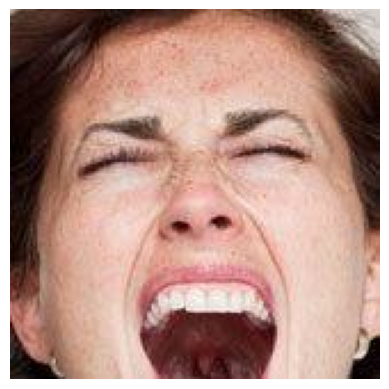

In [18]:
plt.imshow(color)
plt.axis('off')
plt.show()

In [22]:
image = cv.cvtColor(bgr_img, cv.COLOR_BGR2GRAY)
image = cv.resize(image, (100, 100))
image = torch.tensor(image, dtype=torch.float32)
image = image / 255.0
image = image.unsqueeze(0).to(device)
image = image.unsqueeze(0)

In [8]:
import json
import base64

In [12]:
samples_links = {}
for i in emotions:
    samples_links[i] = images_csv[images_csv["label"] == i]["image_path"].sample(n=20, random_state=42).to_list()

In [13]:
samples_links

{'sad': ['/home/adam/Bachelor/emotions/sad/image0022220.jpg',
  '/home/adam/Bachelor/emotions/sad/image0026104.jpg',
  '/home/adam/Bachelor/emotions/sad/image0011063.jpg',
  '/home/adam/Bachelor/emotions/sad/image0017308.jpg',
  '/home/adam/Bachelor/emotions/sad/image0027524.jpg',
  '/home/adam/Bachelor/emotions/sad/image0011845.jpg',
  '/home/adam/Bachelor/emotions/sad/image0025414.jpg',
  '/home/adam/Bachelor/emotions/sad/image0026792.jpg',
  '/home/adam/Bachelor/emotions/sad/image0004069.jpg',
  '/home/adam/Bachelor/emotions/sad/image0029072.jpg',
  '/home/adam/Bachelor/emotions/sad/image0003429.jpg',
  '/home/adam/Bachelor/emotions/sad/image0025911.jpg',
  '/home/adam/Bachelor/emotions/sad/image0015373.jpg',
  '/home/adam/Bachelor/emotions/sad/image0028940.jpg',
  '/home/adam/Bachelor/emotions/sad/image0019574.jpg',
  '/home/adam/Bachelor/emotions/sad/image0030092.jpg',
  '/home/adam/Bachelor/emotions/sad/image0030293.jpg',
  '/home/adam/Bachelor/emotions/sad/image0019742.jpg',
  '

In [16]:
requests = []
for key, values in samples_links.items():
    for link in values:
        with open(link, "rb") as image_file:
            r = str(base64.urlsafe_b64encode(image_file.read()))
            request = {"instances": [r]}
            requests.append(request)

with open("sample.json", "w") as outfile:
    json.dump(requests, outfile)